# CTGAN

Test this at the beginning

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cpu
False


In [ ]:
# pip install ctgan
# pip install sdv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_fscore_support, roc_curve

In [4]:
df = pd.read_csv("data/full_data_cleaned.csv")

### Defining the metadata from cleaned data

In [5]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df)

### Defining the synthesizer

In [ ]:
from sdv.single_table import CTGANSynthesizer

synthesizer = CTGANSynthesizer(metadata,
                               enforce_min_max_values = True,
                               enforce_rounding = True,
                               verbose=True)

c:\Users\Patricia Avram\AppData\Local\Programs\Python\Python311\Lib\site-packages\sdv\single_table\base.py:81: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [8]:
parameters_from_synth = synthesizer.get_parameters()
metadata_from_synth = synthesizer.get_metadata()

print(parameters_from_synth)
print(metadata_from_synth)

{'enforce_min_max_values': True, 'enforce_rounding': True, 'locales': ['en_US'], 'embedding_dim': 128, 'generator_dim': (256, 256), 'discriminator_dim': (256, 256), 'generator_lr': 0.0002, 'generator_decay': 1e-06, 'discriminator_lr': 0.0002, 'discriminator_decay': 1e-06, 'batch_size': 500, 'discriminator_steps': 1, 'log_frequency': True, 'verbose': True, 'epochs': 300, 'pac': 10, 'cuda': True}
{
    "columns": {
        "Make": {
            "sdtype": "categorical"
        },
        "AccidentArea": {
            "sdtype": "categorical"
        },
        "DayOfWeekClaimed": {
            "sdtype": "categorical"
        },
        "MonthClaimed": {
            "sdtype": "categorical"
        },
        "WeekOfMonthClaimed": {
            "sdtype": "numerical"
        },
        "Sex": {
            "sdtype": "categorical"
        },
        "MaritalStatus": {
            "sdtype": "categorical"
        },
        "Fault": {
            "sdtype": "categorical"
        },
        "Polic

### Fitting the data

In [9]:
synthesizer.fit(df)

c:\Users\Patricia Avram\AppData\Local\Programs\Python\Python311\Lib\site-packages\ctgan\synthesizers\_utils.py:16: FutureWarning: `cuda` parameter is deprecated and will be removed in a future release. Please use `enable_gpu` instead.
  warnings.warn(
Gen. (-1.21) | Discrim. (-0.35): 100%|██████████| 300/300 [25:07<00:00,  5.02s/it] 


### Plot the loss values for both the Generator and Discriminator

In [10]:
loss_df = synthesizer.get_loss_values()
print(loss_df)

     Epoch  Generator Loss  Discriminator Loss
0        0        0.929142           -0.966723
1        1       -0.065082           -0.080096
2        2       -0.081421           -0.094798
3        3       -0.171900            0.056233
4        4       -0.176722            0.041588
..     ...             ...                 ...
295    295       -2.251625            0.104978
296    296       -1.301953           -0.634198
297    297       -2.369677           -0.375661
298    298       -2.373313            0.135211
299    299       -1.208267           -0.348812

[300 rows x 3 columns]


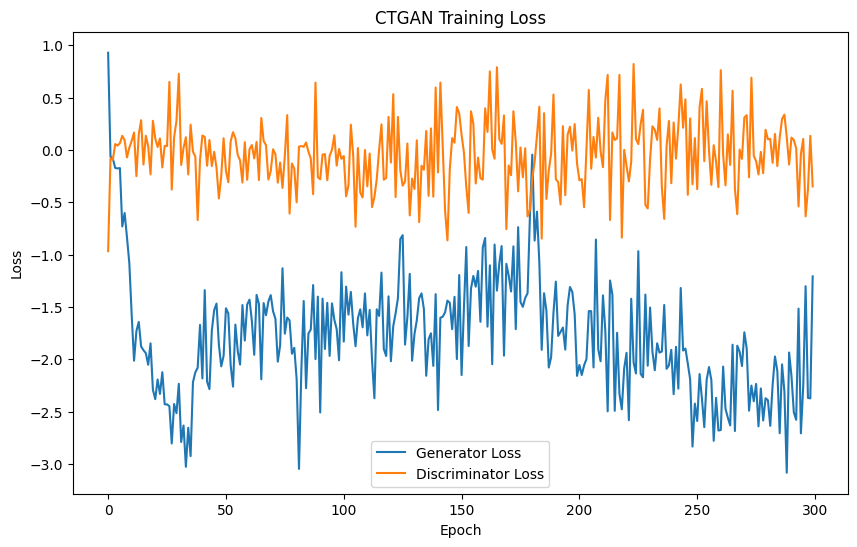

In [11]:
loss_df = loss_df.astype(float)

plt.figure(figsize=(10, 6))
plt.plot(loss_df['Epoch'], loss_df['Generator Loss'], label='Generator Loss')
plt.plot(loss_df['Epoch'], loss_df['Discriminator Loss'], label='Discriminator Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CTGAN Training Loss')
plt.legend()
plt.show()

- From the above plot, it seems like the generator is learning from the discriminator and getting better. Its loss curve drops suddenly at the start of the fitting, and climbs back up gradually.
- In GANs, lower generator loss means the fake samples resemble real samples more closely.
- Loss around 0 can sometimes mean the discriminator is underfitting and not providing enough training signal to the generator. To be explored more
- There seems to be a clear instability or heavy fluctuations in loss in both the generator and discriminator. Need to calculate some sort of metric like accuracy score between the real and synthetic data.

### Sampling from the synthesizer

In [ ]:
synthetic_df = synthesizer.sample(num_rows=len(df))

In [15]:
print(synthetic_df['FraudFound_P'].head(10))
print(df['FraudFound_P'].head(10))

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    1.0
9    0.0
Name: FraudFound_P, dtype: float64
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
9    0.0
Name: FraudFound_P, dtype: float64


### Saving synthesizer

In [16]:
synthesizer.save(filepath='synthesizers/first_synthesizer.pkl')

### To load the synthesizer

In [ ]:
from sdv.utils import load_synthesizer

synthesizer = load_synthesizer(filepath='synthesizers/first_synthesizer.pkl')